In [91]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano 
from scipy.stats import norm
from scipy.stats import t
import math

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

%matplotlib inline

# Configuration

In [135]:
#h1
h1_do_obs                = True
h1_do_bern               = True
resample_h1_obs          = False
resample_h1_bern         = True
folderName_h1_obs        = "h1_obs.trace"
folderName_h1_bern       = "h1_bern.trace"

#h2
h2_do_linear             = True
h2_do_quadratic          = True
resample_h2_linear       = False
resample_h2_quadratic    = False
folderName_h2_linear     = "h2_linear.trace"
folderName_h2_quadratic  = "h2_quadratic.trace"

describeData             = False

remove_rows_not_cells    = True
h1_ropes                 = [("diff_μ", (-4, -0)),("diff_μ", (-4, -1)),               ("diff_μ", (-4, -2))]
h1_bern_ropes            = [("diff_μ", (0, 0.5)),("diff_μ", (0, ((4-1.0)/4.0)*0.5)), ("diff_μ", (0, ((4-2.0)/4.0)*0.5))]
var_names_h1_notRope     = ['log10_ν', 'μ', 'σ', 'diff_σ', 'eff_size', 'eff_size2']
var_names_h1_all         = var_names_h1_notRope.copy().extend([name for name,rope in h1_ropes])

# Helperfunctions

In [3]:
def flatten(lst):
    res = []
    for inner in lst:
        for v in inner:
            res.append(v)
    return res

def getIndexV29(): return 0
def getIndexV31(): return 1
def getIndexV33(): return 2

In [119]:
def getTrace(folder_name, model_name, resample):
    with model_name:
        if (resample):
            trace = pm.sample(10000, chains=4, cores=1, step=pm.NUTS())  #todo argue for choice
            pm.save_trace(trace, folder_name, overwrite=True)
        trace = pm.load_trace(folder_name)
        return trace

def getInferenceData(trace, model_name):
    with model_name:
        return az.from_pymc3(trace, model = model_name)

def standardize(data, m, sd):
    return (data-m)/sd

In [45]:
def plot_trace_method1(trace_inferencedata, var_names, ropes):
    az.plot_posterior(trace_inferencedata, var_names=var_names, kind='hist', figsize=(8,6)
                      , point_estimate='mean', hdi_prob=0.95);
    for (name, rope) in ropes:
        az.plot_posterior(trace_inferencedata, var_names=[name], kind='hist', figsize=(8,2.5)
                      , point_estimate='mean', hdi_prob=0.95, ref_val=0, rope=rope);

def plot_trace_method2(trace, model, var_names):
    az.plot_trace(az.from_pymc3(trace,model=model), var_names=var_names);

def plot_trace_scatter(trace, varnames):
    scatter_matrix(pm.trace_to_dataframe(trace, varnames=varnames), figsize=(20, 10));

def plot_all_data(f_x):
    fig,ax = plt.subplots(figsize=(25,20))
    xprime = np.linspace(1,5,80)
    for i in np.random.randint(0,len(trace_h2_linear),100):
        ax.plot(xprime, f_x(xprime, i), color='lightsteelblue')

    # Define spectrum of colors
    number_of_plots=len(communities)
    colormap = plt.cm.nipy_spectral
    colors = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]
    ax.set_prop_cycle('color', colors)

    [ax.plot(get_relevant(com, getIndexV29())[1], get_relevant(com, getIndexV31())[1], "-", marker='o', label=com) for com in communities]

    plt.legend(loc='best')
    plt.show()

# load data

In [6]:
df = pd.read_csv('pseudonymized-data.csv')
df = df.rename(columns={df.columns[0]: 'id'})

df = df[["id", "Community", "V29", "V31", "V33"]]
df = df[df["Community"] != "-1"]

if remove_rows_not_cells:
    for col in df.iloc[:,2:].columns:
        df = df[df[col] != -1]

In [111]:
def removeNoAnswer(lst):
    return lst if remove_rows_not_cells else [i for i in lst if i!=-1]

data = []
communities = df.Community.unique();
for com in communities:
    columns  = []
    for question in df.iloc[:,2:].columns:
        columns.append(removeNoAnswer(df[df.Community == com][question].to_numpy()))
    positive = [[0.5 if d==3 else int(d<=3) for d in v] for v in columns]

    N = [len(v) for v in columns]
    μ = [np.mean(v) for v in columns]
    σ = [np.std(v) for v in columns]
    
    N_bern = [len(v) for v in positive]
    μ_bern = [np.mean(v) for v in positive]
    σ_bern = [np.std(v) for v in positive]
    all = (com, columns, positive, N, μ, σ, N_bern, μ_bern, σ_bern)
    data.append(all)

def get_all_data ():
    return data
    
def get_relevant(com, dataIndex):
    (com, columns, positive, N, μ, σ, N_bern, μ_bern, σ_bern) = next(filter(lambda lst : lst[0]==com, data))
    return (com, columns[dataIndex], positive[dataIndex], N[dataIndex], μ[dataIndex], σ[dataIndex], N_bern[dataIndex], μ_bern[dataIndex], σ_bern[dataIndex])

In [8]:
df.head() if describeData else None

In [9]:
df.iloc[:,2:].describe() if describeData else None

In [10]:
if describeData:
    df.hist(column=df.columns[1:], bins=50, figsize=(20,3), layout=(1,3))
    plt.show()

### H1
The Coala Community is more lenient than the Linux Kernel Community.

#### Decision Rules - for reference
The basic principle 
 
- Decision Rule 1. If the null value is far from credible values: reject the hypothesis 
- Decision Rule 2. If all credible values are practically equivalent to the null value: accept the hypothesis 
- **Example.** If we want to prove that a coin is biased, we want to reject the null value of 0.5

Null value - draft
- The Likert scale value of Coala community is greater than that of Linux Kernel Community
- The difference is non zero - 95% HDI of difference doesn't overlap with ROPE of zero - (maybe +-.25 of the scale ~0.5%)
- Our null hypothesis is that the Coala Community is more lenient than the Linux Kernel Community if **(μ_coala - μ_linux) < -1**




In [113]:
(com_coala, obs_coala, bern_coala, N_coala_obs, μ_coala_obs, σ_coala_obs, N_coala_bern, μ_coala_bern, σ_coala_bern)=get_relevant("Comm.Coala", getIndexV33())
(com_linux, obs_linux, bern_linux, N_linux_obs, μ_linux_obs, σ_linux_obs, N_linux_bern, μ_linux_bern, σ_linux_bern)=get_relevant("Comm.Linux_Kernel", getIndexV33())

if describeData  or True:
    print("com: ",com_coala, com_linux)
    print("obs: ",obs_coala, obs_linux)
    print("N: ", N_coala_obs, N_linux_obs)
    print("μ: ", μ_coala_obs, μ_linux_obs)
    print("σ: ", σ_coala_obs, σ_linux_obs)
    print("p: ", bern_coala, bern_linux)
    print("N: ", N_coala_bern, N_linux_bern)
    print("μ: ", μ_coala_bern, μ_linux_bern)
    print("σ: ", σ_coala_bern, σ_linux_bern)

com:  Comm.Coala Comm.Linux_Kernel
obs:  [2 1 2 2 1 2 2] [2 4 4 3 3 1 2 3 2 3 3 4 3 4 2 2 3 4]
N:  7 18
μ:  1.7142857142857142 2.888888888888889
σ:  0.45175395145262565 0.8748897637790901
p:  [1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 0.5, 0.5, 1, 1, 0.5, 1, 0.5, 0.5, 0, 0.5, 0, 1, 1, 0.5, 0]
N:  7 18
μ:  1.0 0.5277777777777778
σ:  0.0 0.38987969021161667


### H1 Model description

In [116]:
def makeModel(data_coala, data_linux, data_μ_coala, data_μ_linux, data_σ_coala, data_σ_linux):
    data_σ_coala = np.max([1/1000,data_σ_coala])
    data_σ_linux = np.max([1/1000,data_σ_linux])
    with pm.Model() as model_h1:
        μ_noData = pm.Normal('μ_noData', mu=1, sigma=100*1, shape=2)
        μ        = pm.Deterministic('μ', μ_noData*[data_μ_coala, data_μ_linux])
        σ_noData = pm.Uniform('σ_noData', lower=1/1000, upper=1*1000, shape=2)
        σ        = pm.Deterministic('σ', σ_noData*[data_σ_coala, data_σ_linux])
        ν_minus_one = pm.Exponential('ν_minus_one', lam=1/29)
        ν = pm.Deterministic('ν', ν_minus_one+1)

        # for plotting/comparison purposes
        log10_ν = pm.Deterministic('log10_ν',np.log10(ν))
        eff_size = pm.Deterministic('eff_size',(μ-100)/σ)
        
        eff_size2 = pm.Deterministic('eff_size2',((μ[0]-μ[1])/np.sqrt((σ[0]**2+σ[1]**2)/2)))
        
        #likelihood
        obs_coala   = pm.StudentT('obs_coala',  nu=ν, mu=μ[0], sd=σ[0], observed=data_coala)
        obs_linux   = pm.StudentT('obs_linux',  nu=ν, mu=μ[1], sd=σ[1], observed=data_linux)

        #differences
        diff_μ   = pm.Deterministic('diff_μ', μ[0]-μ[1])
        diff_σ   = pm.Deterministic('diff_σ', σ[0]-σ[1])
    return model_h1

In [120]:
model_h1_obs  = makeModel(obs_coala,  obs_linux,  μ_coala_obs,  μ_linux_obs,  σ_coala_obs,  σ_linux_obs)  if h1_do_obs else None
model_h1_bern = makeModel(bern_coala, bern_linux, μ_coala_bern, μ_linux_bern, σ_coala_bern, σ_linux_bern) if h1_do_bern else None

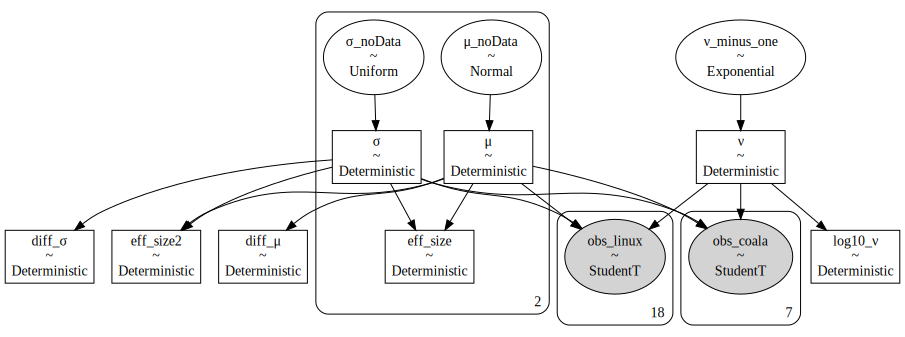

In [98]:
pm.model_to_graphviz(model_h1_obs)  if h1_do_obs else None

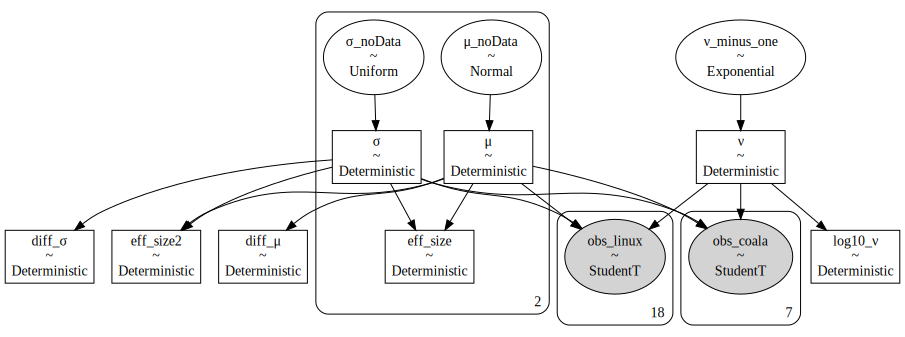

In [99]:
pm.model_to_graphviz(model_h1_bern) if h1_do_bern else None

In [121]:
trace_h1_obs = getTrace(folderName_h1_obs,  model_h1_obs,  resample_h1_obs)  if h1_do_obs else None
trace_h1_inferencedata_obs = getInferenceData(trace_h1_obs, model_h1_obs)    if h1_do_obs else None

In [122]:
trace_h1_bern = getTrace(folderName_h1_bern, model_h1_bern, resample_h1_bern) if h1_do_bern else None
trace_h1_inferencedata_bern = getInferenceData(trace_h1_bern, model_h1_bern)  if h1_do_bern else None

Sequential sampling (4 chains in 1 job)
NUTS: [ν_minus_one, σ_noData, μ_noData]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 63 seconds.


### H1 Model analysis

In [103]:
az.summary(trace_h1_obs)  if h1_do_obs  else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.011,0.152,0.726,1.295,0.001,0.001,19120.0,18070.0,23349.0,17527.0,1.0
μ_noData[1],1.003,0.082,0.848,1.156,0.000,0.000,29211.0,29211.0,29739.0,25687.0,1.0
μ[0],1.733,0.260,1.244,2.220,0.002,0.001,19120.0,18070.0,23349.0,17527.0,1.0
μ[1],2.898,0.237,2.450,3.340,0.001,0.001,29211.0,29211.0,29739.0,25687.0,1.0
σ_noData[0],1.356,0.578,0.570,2.371,0.004,0.003,16689.0,14493.0,22211.0,19005.0,1.0
σ_noData[1],1.081,0.217,0.718,1.498,0.001,0.001,29234.0,27911.0,30721.0,26555.0,1.0
σ[0],0.613,0.261,0.258,1.071,0.002,0.002,16689.0,14493.0,22211.0,19005.0,1.0
σ[1],0.946,0.190,0.628,1.310,0.001,0.001,29234.0,27911.0,30721.0,26555.0,1.0
ν_minus_one,35.211,29.803,0.724,88.673,0.175,0.124,28984.0,28984.0,22986.0,18297.0,1.0
ν,36.211,29.803,1.724,89.673,0.175,0.124,28984.0,28984.0,22986.0,18297.0,1.0


In [123]:
az.summary(trace_h1_bern) if h1_do_bern else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000,0.000,30439.0,30439.0,32987.0,24488.0,1.0
μ_noData[1],1.004000e+00,2.000000e-01,6.310000e-01,1.386000e+00,0.001,0.001,36627.0,36274.0,37040.0,27995.0,1.0
μ[0],1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000,0.000,30439.0,30439.0,32987.0,24488.0,1.0
μ[1],5.300000e-01,1.060000e-01,3.330000e-01,7.320000e-01,0.001,0.000,36627.0,36274.0,37040.0,27995.0,1.0
σ_noData[0],1.000000e-03,0.000000e+00,1.000000e-03,2.000000e-03,0.000,0.000,27562.0,25540.0,25354.0,17633.0,1.0
σ_noData[1],1.095000e+00,2.150000e-01,7.390000e-01,1.496000e+00,0.001,0.001,36867.0,33887.0,39995.0,30698.0,1.0
σ[0],0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,27562.0,25540.0,25354.0,17633.0,1.0
σ[1],4.270000e-01,8.400000e-02,2.880000e-01,5.830000e-01,0.000,0.000,36867.0,33887.0,39995.0,30698.0,1.0
ν_minus_one,3.841400e+01,3.103500e+01,9.520000e-01,9.417700e+01,0.164,0.124,35612.0,31555.0,32500.0,25474.0,1.0
ν,3.941400e+01,3.103500e+01,1.952000e+00,9.517700e+01,0.164,0.123,35612.0,31614.0,32500.0,25474.0,1.0


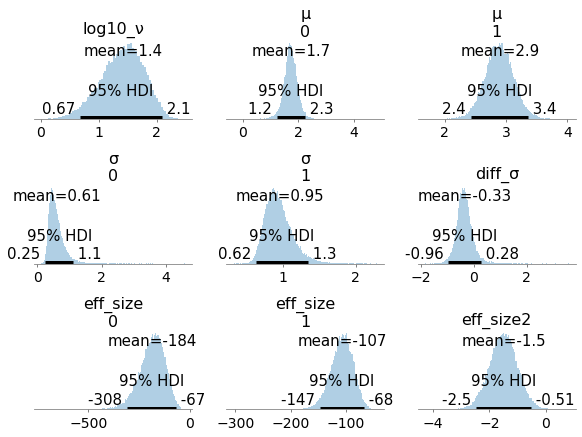

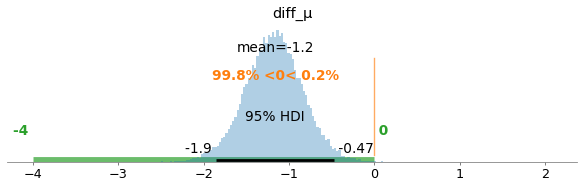

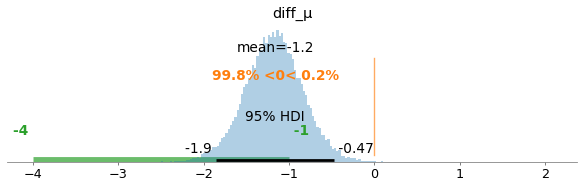

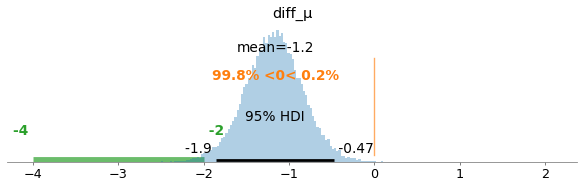

In [136]:
plot_trace_method1(trace_h1_inferencedata_obs,  var_names_h1_notRope, h1_ropes) if h1_do_obs  else None

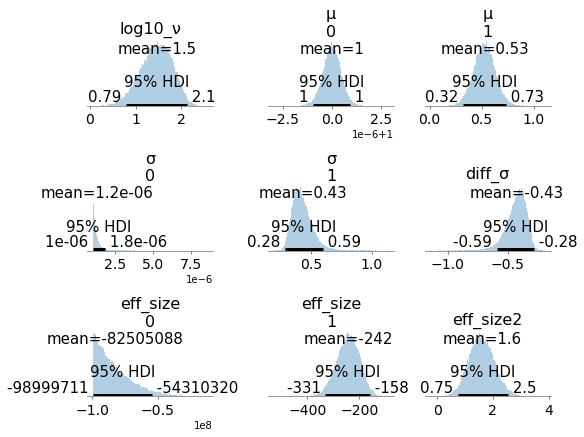

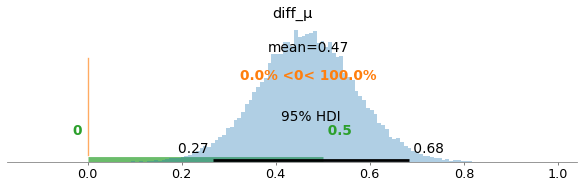

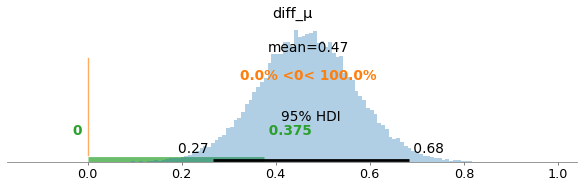

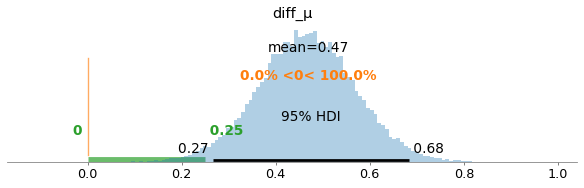

In [137]:
plot_trace_method1(trace_h1_inferencedata_bern, var_names_h1_notRope, h1_bern_ropes) if h1_do_bern else None

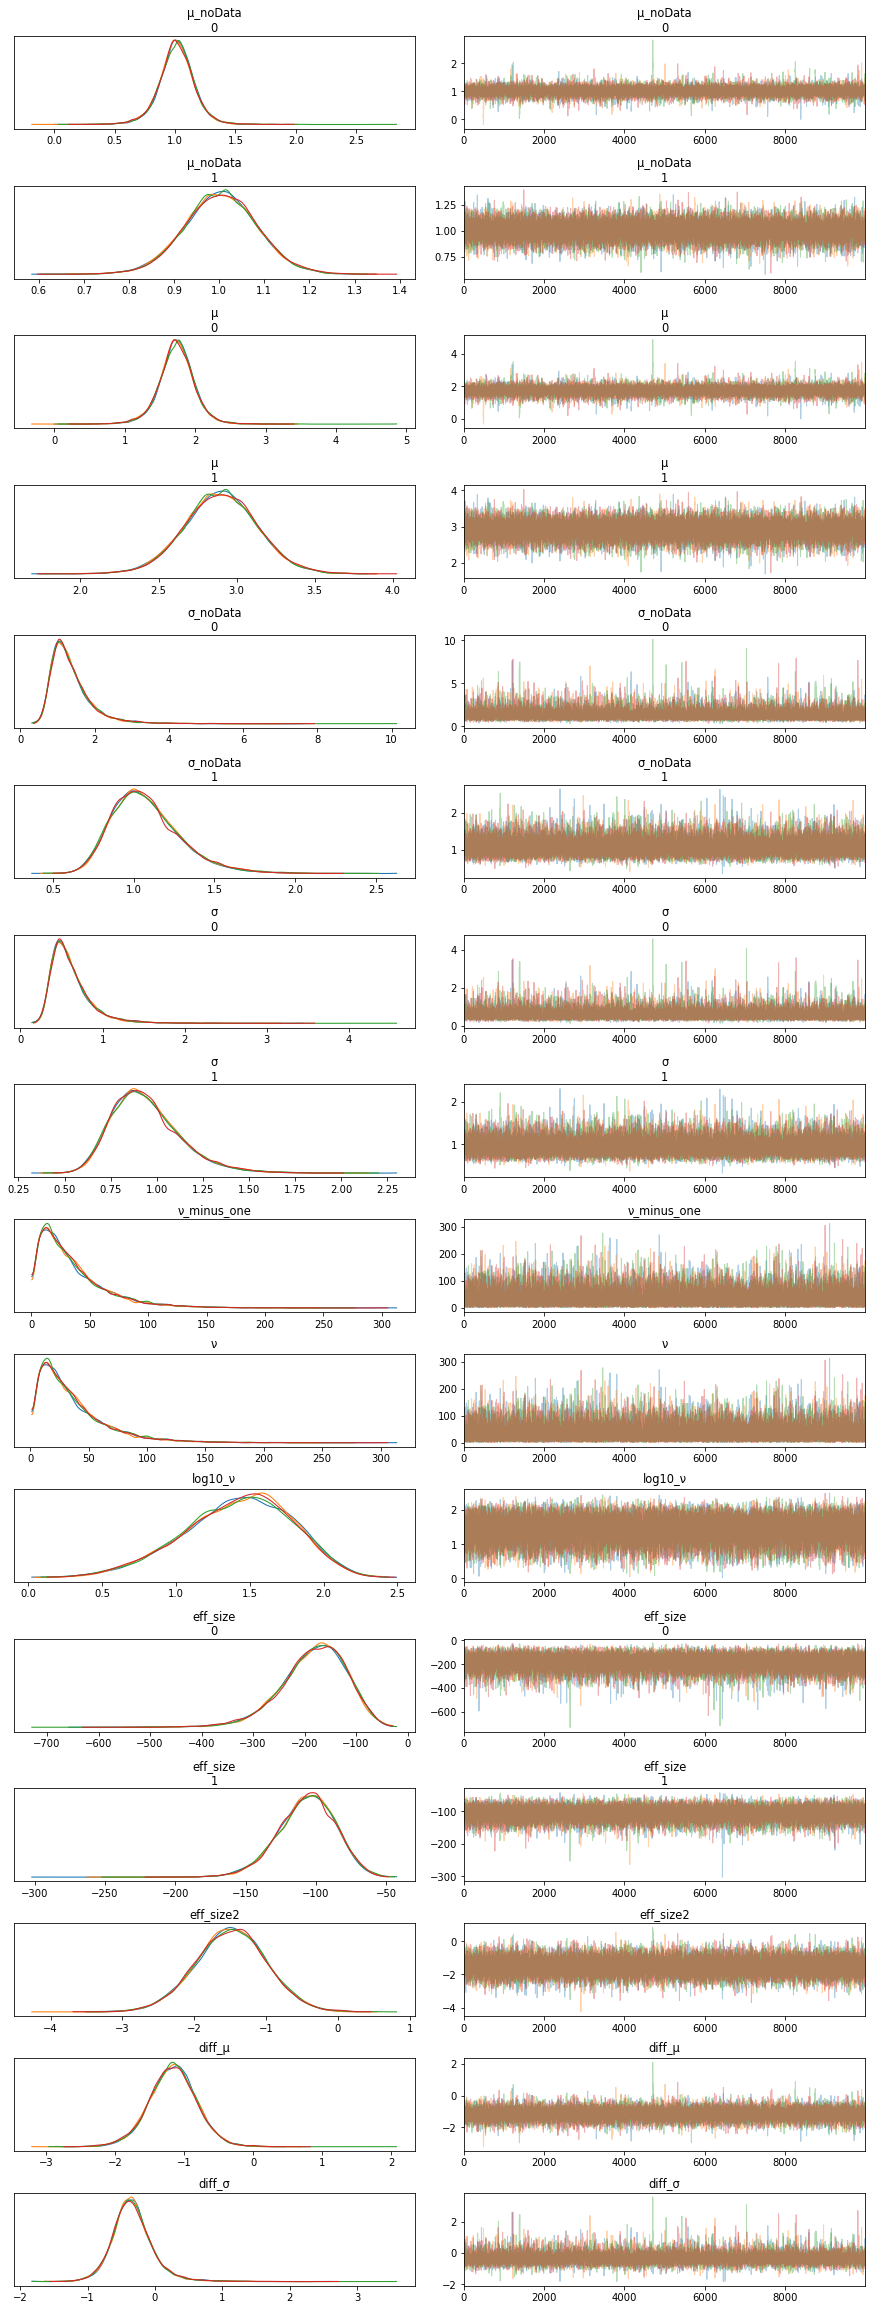

In [107]:
plot_trace_method2(trace_h1_obs, model_h1_obs, var_names_h1_all) if h1_do_obs  else None

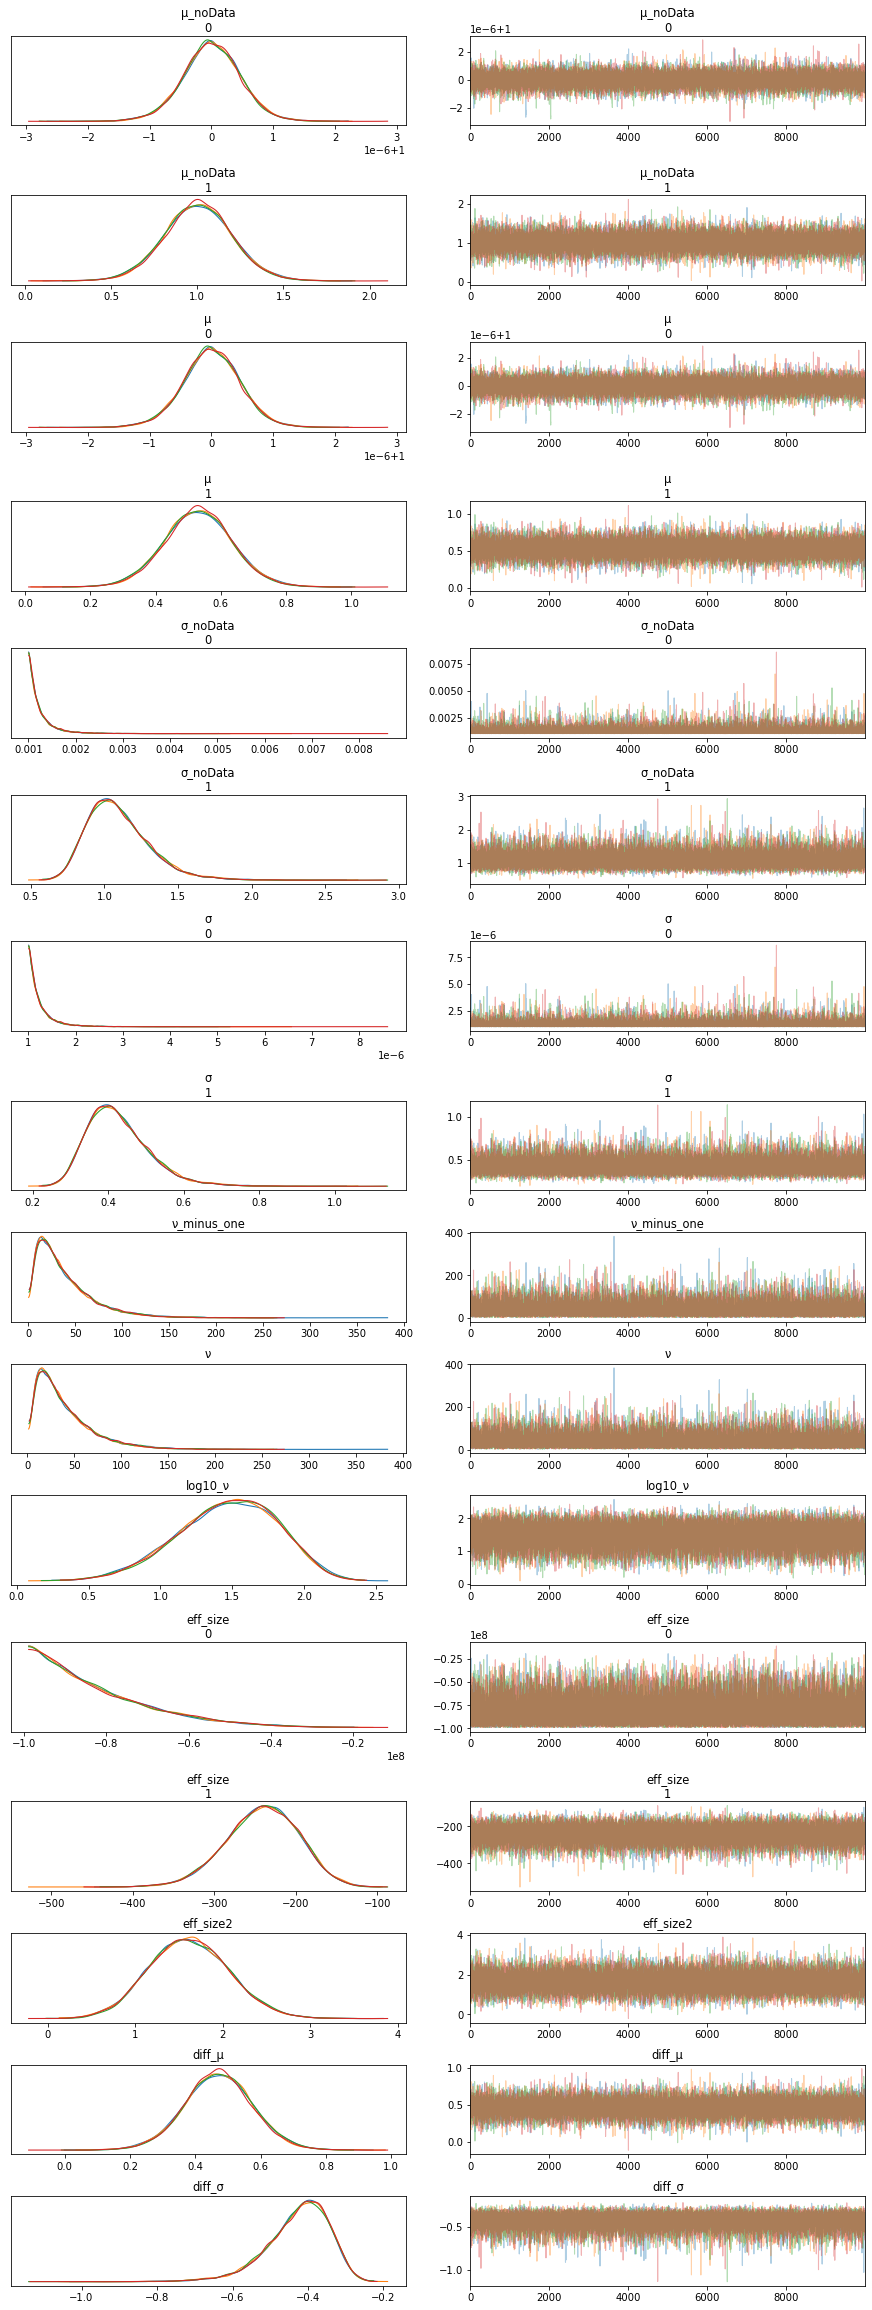

In [126]:
plot_trace_method2(trace_h1_bern, model_h1_bern, var_names_h1_all) if h1_do_bern  else None

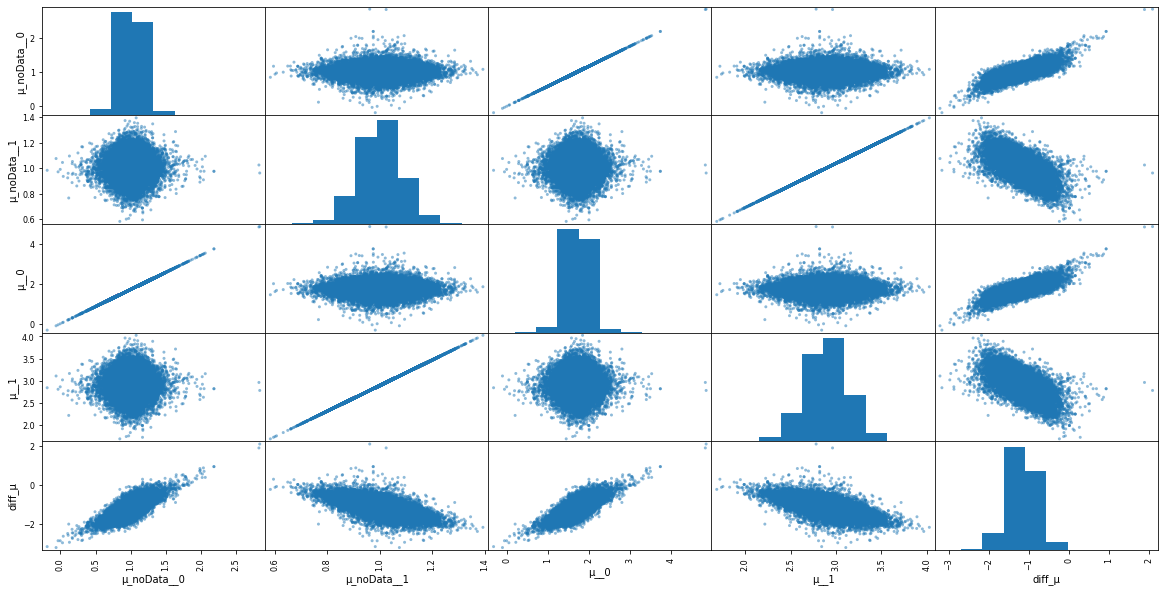

In [109]:
plot_trace_scatter(trace_h1_obs, ['μ_noData', 'μ', 'diff_μ'])

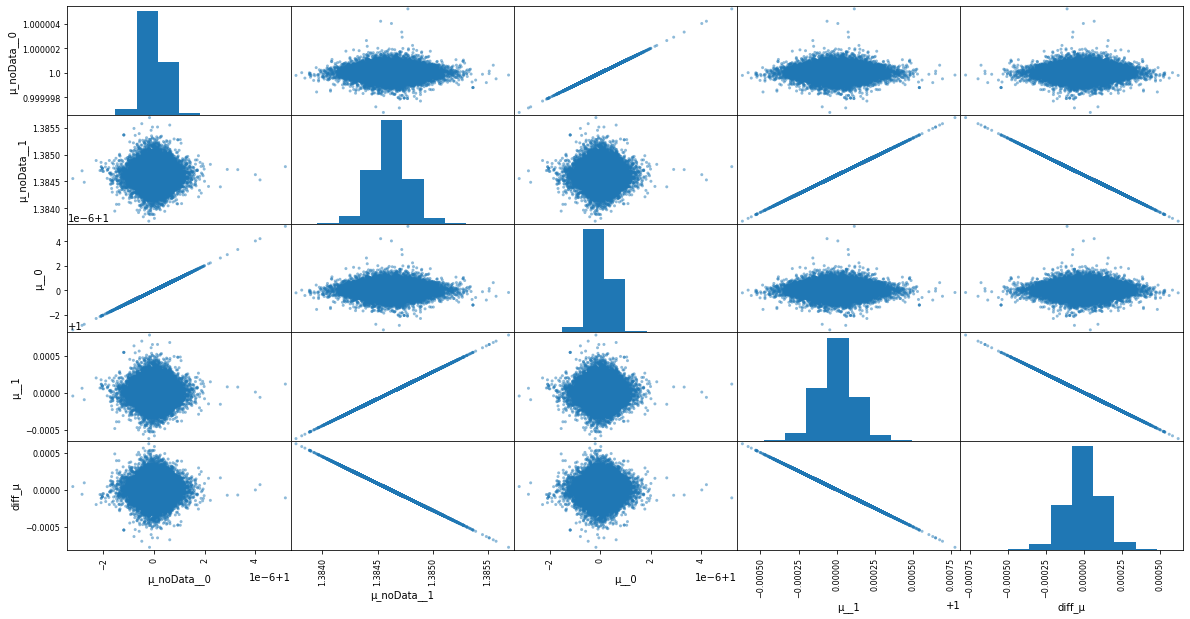

In [110]:
plot_trace_scatter(trace_h1_bern, ['μ_noData', 'μ', 'diff_μ'])

## H1 discussion

## H2

All communities show either a protective or equitable style of governance for pull requests (so for each community answers to V29 and V31 are different)

## Model h2

In [26]:
V29_norm = flatten([get_relevant(com, getIndexV29())[1] for com in communities])
V31_norm = flatten([get_relevant(com, getIndexV31())[1] for com in communities])
idxs = flatten([[i for v in get_relevant(com, getIndexV29())[1]] for (i,com) in enumerate(communities)])
com_ids = range(len(communities))
m_29 = np.mean(V29_norm)
m_31 = np.mean(V31_norm)
sd_29 = np.std(V29_norm)
sd_31 = np.std(V31_norm)
V29 = standardize(V29_norm, m_29, sd_29)
V31 = standardize(V31_norm, m_31, sd_31)

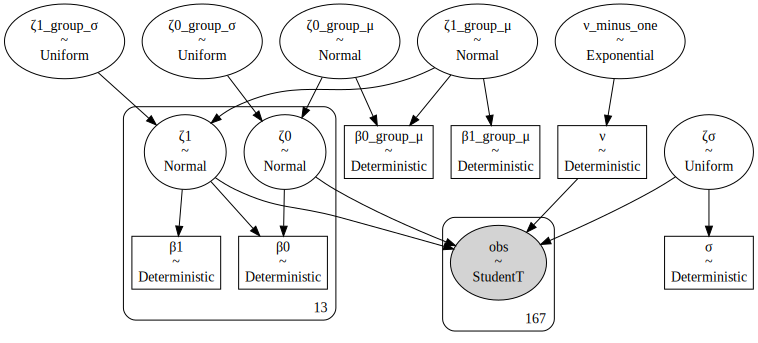

In [27]:
with pm.Model() as model_h2_linear:
    # Prior
    ζ0_group_μ = pm.Normal('ζ0_group_μ',mu=0,sigma=10)
    ζ1_group_μ = pm.Normal('ζ1_group_μ',mu=0,sigma=10)
    ζ0_group_σ = pm.Uniform('ζ0_group_σ',lower=1/1000,upper=1000)
    ζ1_group_σ = pm.Uniform('ζ1_group_σ',lower=1/1000,upper=1000)
    
    ζσ = pm.Uniform('ζσ',lower=1/1000,upper=1000)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)
    
    ζ0 = pm.Normal('ζ0',mu=ζ0_group_μ, sigma=ζ0_group_σ, shape=len(communities))
    ζ1 = pm.Normal('ζ1',mu=ζ1_group_μ, sigma=ζ1_group_σ, shape=len(communities))
    
    
    pm.StudentT('obs',
            nu=ν,
            mu=ζ0[idxs]+ζ1[idxs]*V29,
            sigma=ζσ,
            observed=V31)
    
    #transforming data back
    β0 = pm.Deterministic('β0', (ζ0*sd_31) + m_31 - (ζ1*m_29*sd_31/sd_29))
    β1 = pm.Deterministic('β1', ζ1*sd_31/sd_29)
    
    
    β0_group_μ = pm.Deterministic('β0_group_μ', (ζ0_group_μ*sd_31) + m_31 - (ζ1_group_μ*m_29*sd_31/sd_29))
    β1_group_μ = pm.Deterministic('β1_group_μ', ζ1_group_μ*sd_31/sd_29)

    σ = pm.Deterministic('σ', ζσ)

pm.model_to_graphviz(model_h2_linear)

In [28]:
trace_h2_linear = getTrace(folderName_h2_linear, model_h2_linear, resample_h2_linear)  if h2_do_linear else None
trace_h2_inferencedata_linear = getInferenceData(trace_h2_linear, model_h2_linear)     if h2_do_linear else None

In [29]:
az.summary(trace_h2_linear) if h2_do_linear else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ζ0_group_μ,-0.011,0.153,-0.278,0.282,0.011,0.007,213.0,213.0,185.0,10907.0,1.02
ζ1_group_μ,-0.127,0.111,-0.338,0.084,0.002,0.001,3280.0,2941.0,2577.0,2584.0,1.01
ζ0[0],-0.353,0.177,-0.688,-0.053,0.014,0.010,152.0,152.0,158.0,985.0,1.02
ζ0[1],0.085,0.181,-0.234,0.423,0.019,0.013,95.0,95.0,100.0,2202.0,1.03
ζ0[2],0.008,0.264,-0.494,0.504,0.015,0.010,317.0,317.0,311.0,10456.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...
β1[11],-0.048,0.120,-0.268,0.181,0.006,0.004,362.0,362.0,353.0,1179.0,1.02
β1[12],-0.167,0.186,-0.550,0.170,0.002,0.003,6047.0,1685.0,5698.0,15762.0,1.06
β0_group_μ,2.541,0.448,1.732,3.450,0.008,0.007,2894.0,2152.0,2835.0,2018.0,1.06
β1_group_μ,-0.120,0.105,-0.321,0.080,0.002,0.001,3280.0,2941.0,2577.0,2584.0,1.01


In [69]:
var_names_h2_linear=['β0_group_μ','β1_group_μ','ν']

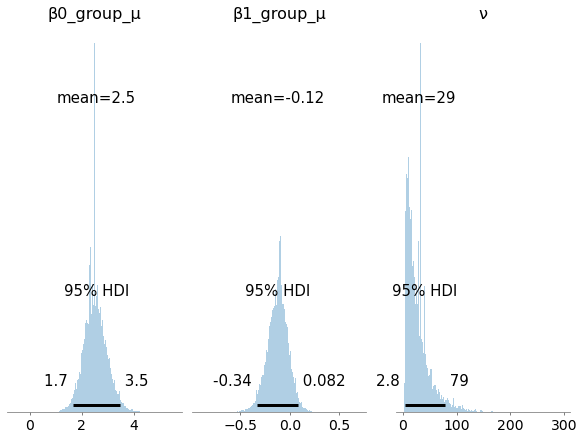

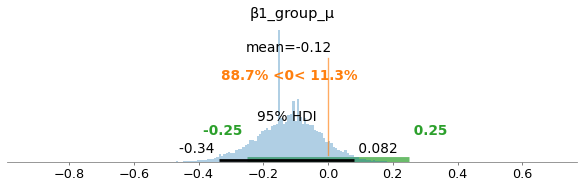

In [73]:
plot_trace_method1(trace_h2_inferencedata_linear, var_names_h2_linear, [("β1_group_μ", (-0.25, 0.25))])

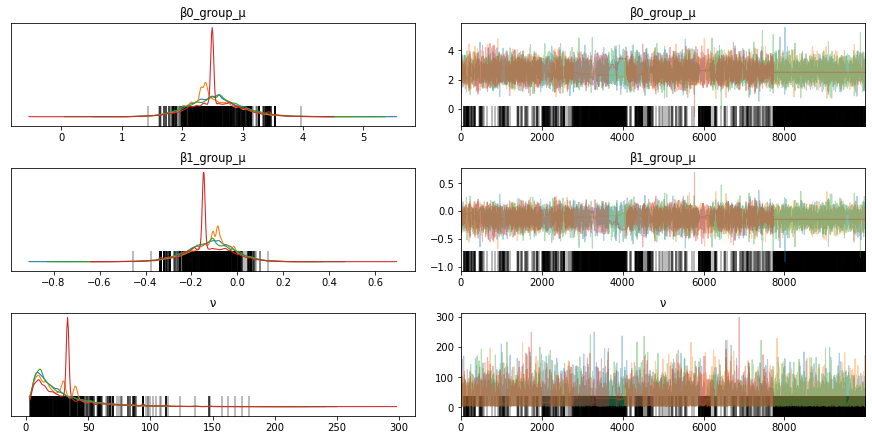

In [32]:
plot_trace_method2(trace_h2_linear, model_h2_linear, var_names_h2)

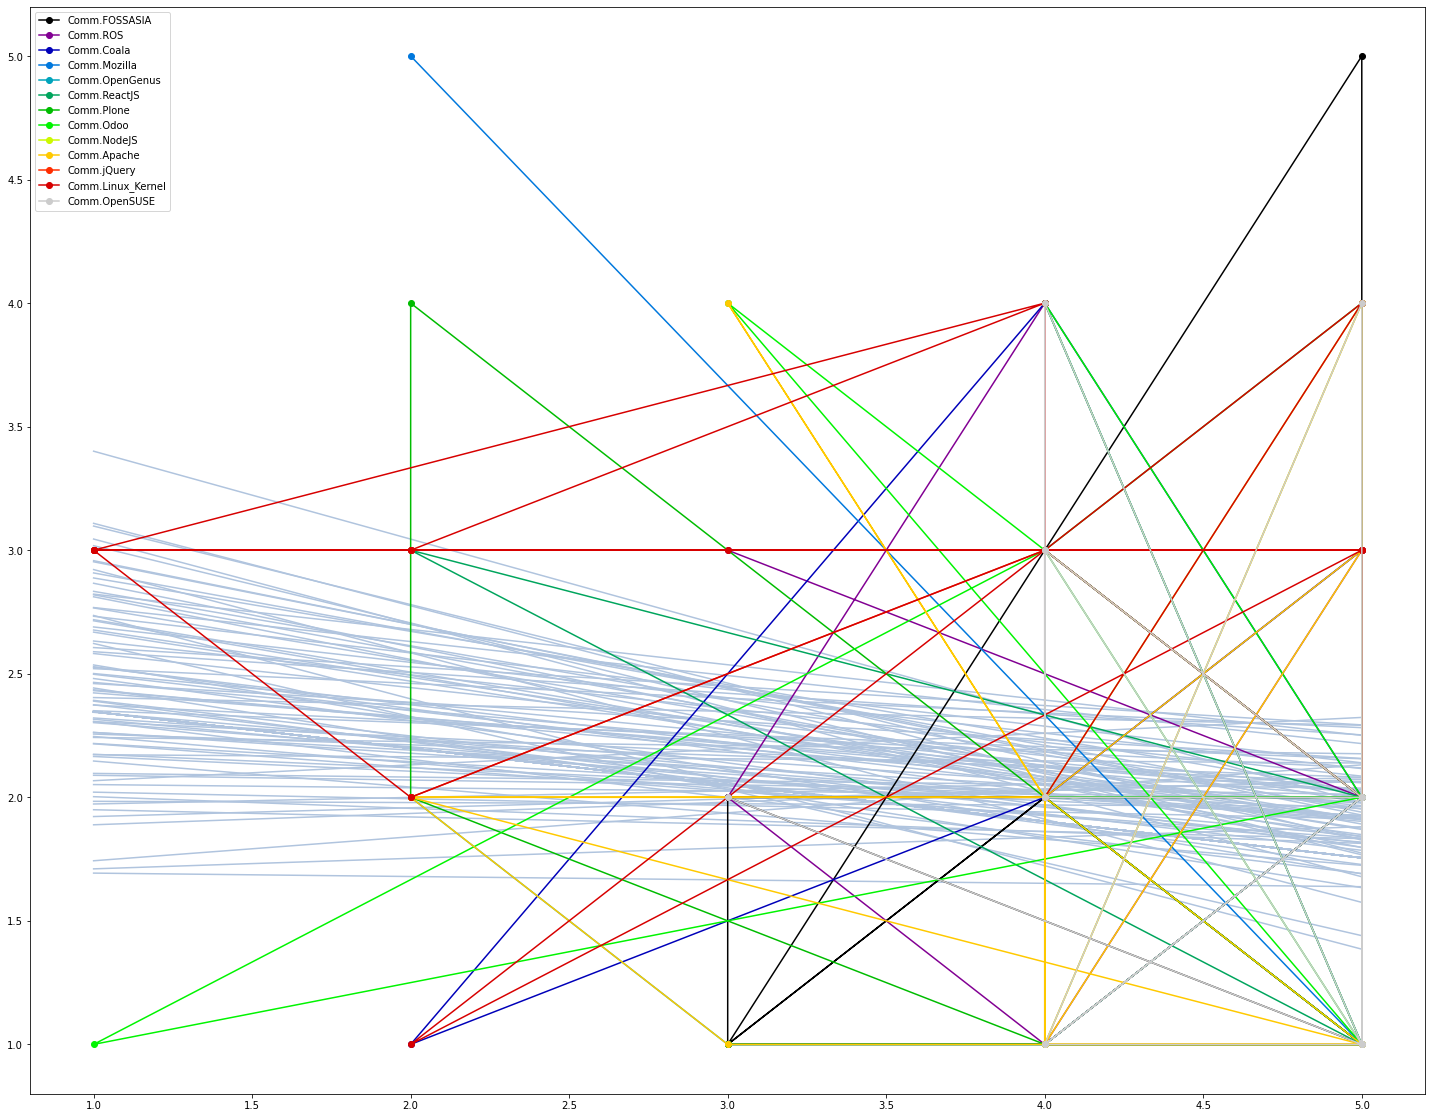

In [33]:
linFunction = lambda xprime, i: trace_h2_linear[i]['β0_group_μ']+trace_h2_linear[i]['β1_group_μ']*xprime
plot_all_data(linFunction)

In [34]:
def plot_com_reg_data(com_id,trace,num_ppc,ax,hdi=False):    
    V29_to_plot = np.array(get_relevant(communities[com_id], getIndexV29())[1])
    xprime = np.linspace(1,5,len(V29_to_plot))
    
    # Plot regression lines
    if not hdi:
        [ax.plot(xprime,
                 trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29,
                 color='lightsteelblue')
         for i in np.random.randint(0,len(trace),num_ppc)]
    
    # Plot hdi
    else:
        az.plot_hdi(xprime,
                    [t.rvs(df=trace[i]['ν'],
                           loc=trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29_to_plot, 
                           scale=trace[i]['σ'])
                     for i in np.random.randint(low=0, high=len(trace), size=num_ppc)],
                    color='lightblue',
                    hdi_prob=0.95,
                    ax=ax)

    ax.plot(get_relevant(communities[com_id], getIndexV29())[1], get_relevant(communities[com_id], getIndexV31())[1],
             marker='o',linestyle=None,color='black',lw=0,
             label=communities[com_id])
#     ax.plot(get_relevant(com_id, 2)[1], get_relevant(com, 4)[1], "-", marker='o', color='black',lw=.8, label=com_id)


    ax.set_xlim(1,5)
    ax.set_ylim(-1,5)
    ax.set_title(communities[com_id])

C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Minic

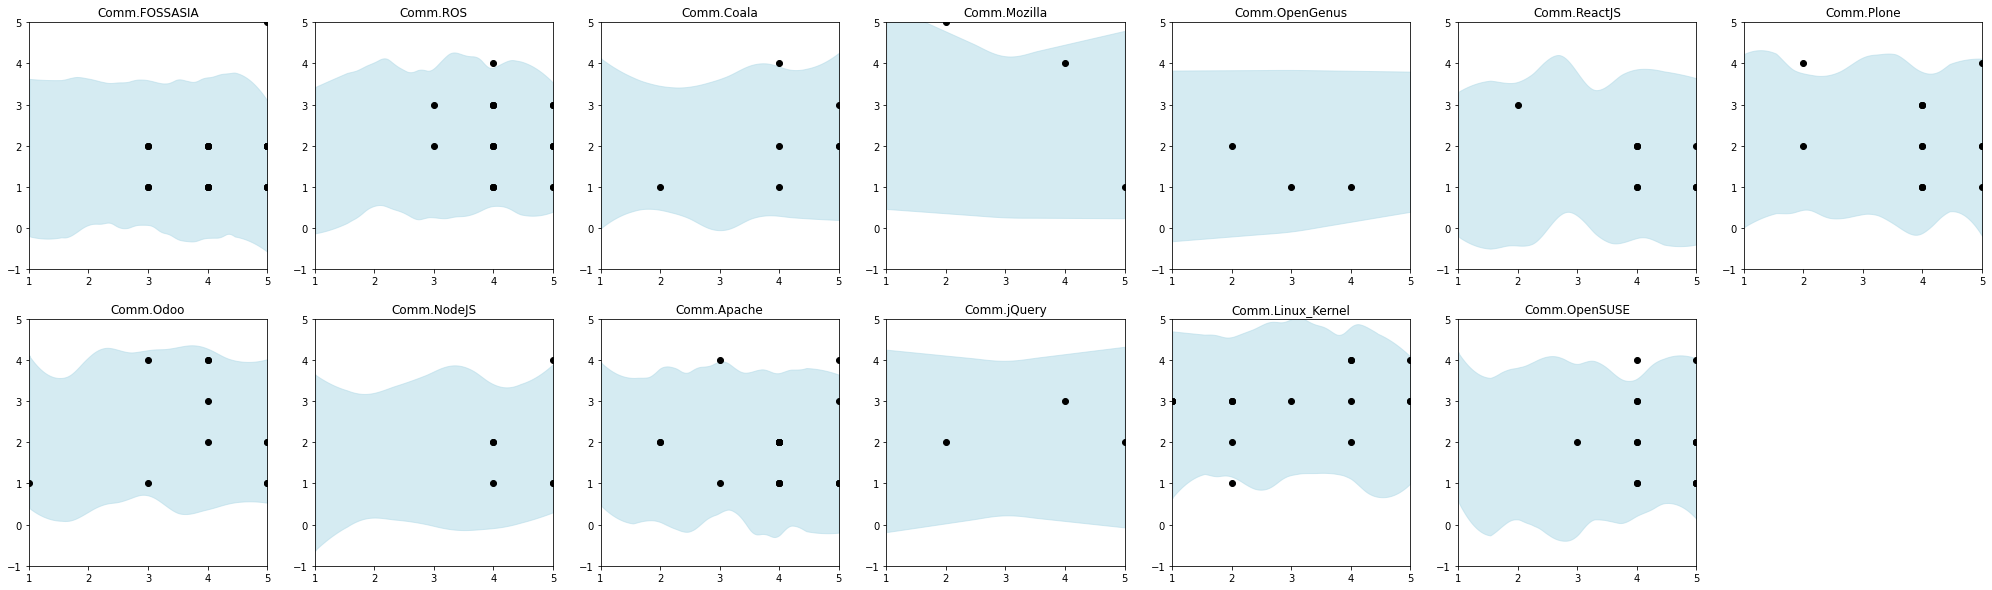

In [35]:
#plot individual
fig, axs = plt.subplots(nrows=2,ncols=7, figsize=(35,10))
flatten_axs = axs.ravel()
[plot_com_reg_data(com_id=com_id,trace=trace_h2_linear,num_ppc=100,ax=ax,hdi=True) for (com_id,ax) in zip(com_ids,flatten_axs)]
[flatten_axs[i].axis('off') for i in range(len(com_ids),len(flatten_axs))]
plt.show()

### Quadratic

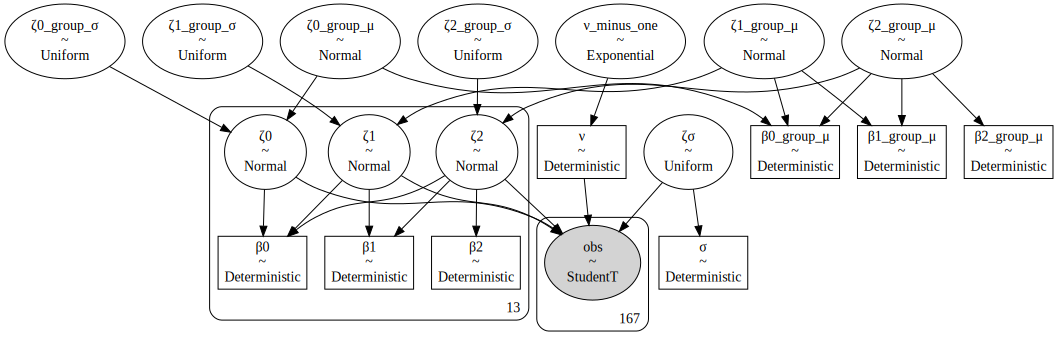

In [36]:
with pm.Model() as model_h2_quadratic:
    ζ0_group_μ = pm.Normal('ζ0_group_μ',mu=0,sigma=10)
    ζ1_group_μ = pm.Normal('ζ1_group_μ',mu=0,sigma=10)
    ζ2_group_μ = pm.Normal('ζ2_group_μ',mu=0,sigma=10)

    ζ0_group_σ = pm.Uniform('ζ0_group_σ',lower=1/1000,upper=1000)
    ζ1_group_σ = pm.Uniform('ζ1_group_σ',lower=1/1000,upper=1000)
    ζ2_group_σ = pm.Uniform('ζ2_group_σ',lower=1/1000,upper=1000)

    ζσ = pm.Uniform('ζσ',lower=1/1000,upper=1000)

    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    ζ0 = pm.Normal('ζ0',mu=ζ0_group_μ, sigma=ζ0_group_σ, shape=len(communities))
    ζ1 = pm.Normal('ζ1',mu=ζ1_group_μ, sigma=ζ1_group_σ, shape=len(communities))
    ζ2 = pm.Normal('ζ2',mu=ζ2_group_μ, sigma=ζ2_group_σ, shape=len(communities))

    pm.StudentT('obs',
                nu=ν,
                mu=ζ0[idxs]+ζ1[idxs]*V29+ζ2[idxs]*V29**2,
                sigma=ζσ,
                observed=V31)

    # Transform Data
    β2 = pm.Deterministic('β2', ζ2*sd_31/(sd_29**2))
    β1 = pm.Deterministic('β1', ζ1*sd_31/sd_29 - 2*ζ2*m_29*sd_31/(sd_29**2))
    β0 = pm.Deterministic('β0', ζ0*sd_31+m_31-ζ1*m_29*sd_31/sd_29+ζ2*(m_29**2)*sd_31/(sd_29**2))

    β2_group_μ = pm.Deterministic('β2_group_μ', ζ2_group_μ*sd_31/(sd_29**2))
    β1_group_μ = pm.Deterministic('β1_group_μ', ζ1_group_μ*sd_31/sd_29 - 2*ζ2_group_μ*m_29*sd_31/(sd_29**2))
    β0_group_μ = pm.Deterministic('β0_group_μ', ζ0_group_μ*sd_31+m_31-ζ1_group_μ*m_29*sd_31/sd_29+ζ2_group_μ*(m_29**2)*sd_31/(sd_29**2))

    σ = pm.Deterministic('σ', ζσ*sd_31)
pm.model_to_graphviz(model_h2_quadratic)

In [37]:
trace_h2_quadratic = getTrace(folderName_h2_quadratic, model_h2_quadratic, resample_h2_quadratic)  if h2_do_quadratic else None
trace_h2_inferencedata_quadratic = getInferenceData(trace_h2_quadratic, model_h2_quadratic)        if h2_do_quadratic else None

In [38]:
az.summary(trace_h2_quadratic) if h2_do_quadratic else None

C:\ProgramData\Miniconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ζ0_group_μ,0.028,0.170,-0.291,0.348,0.003,0.002,4066.0,4066.0,4026.0,4854.0,1.00
ζ1_group_μ,-0.137,0.133,-0.389,0.113,0.002,0.002,3277.0,3277.0,3122.0,9380.0,1.00
ζ2_group_μ,-0.017,0.095,-0.192,0.168,0.002,0.001,2730.0,2730.0,2602.0,11939.0,1.00
ζ0[0],-0.368,0.188,-0.707,-0.005,0.004,0.003,2389.0,2389.0,2405.0,7470.0,1.00
ζ0[1],0.108,0.189,-0.249,0.453,0.005,0.004,1261.0,1261.0,1270.0,9734.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
β0[12],1.951,2.696,-3.297,7.108,0.027,0.019,9788.0,9788.0,8683.0,15130.0,1.00
β2_group_μ,-0.015,0.086,-0.173,0.151,0.002,0.001,2730.0,2730.0,2602.0,11939.0,1.00
β1_group_μ,-0.009,0.655,-1.270,1.199,0.012,0.009,2911.0,2911.0,2710.0,7046.0,1.00
β0_group_μ,2.378,1.263,-0.132,4.643,0.024,0.017,2737.0,2737.0,2492.0,2131.0,1.00


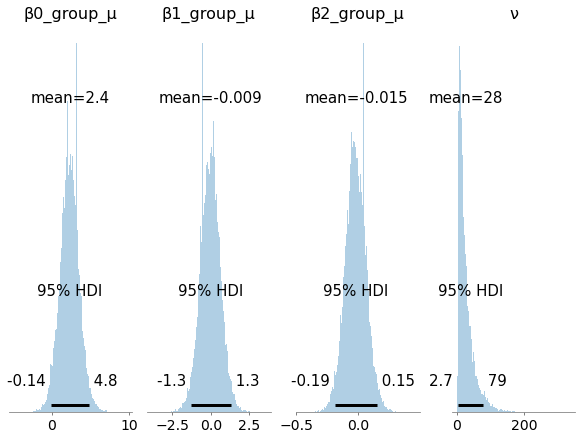

In [39]:
var_names_h2=['β0_group_μ','β1_group_μ','β2_group_μ','ν']
plot_trace_method1(trace_h2_inferencedata_quadratic, var_names_h2, [])

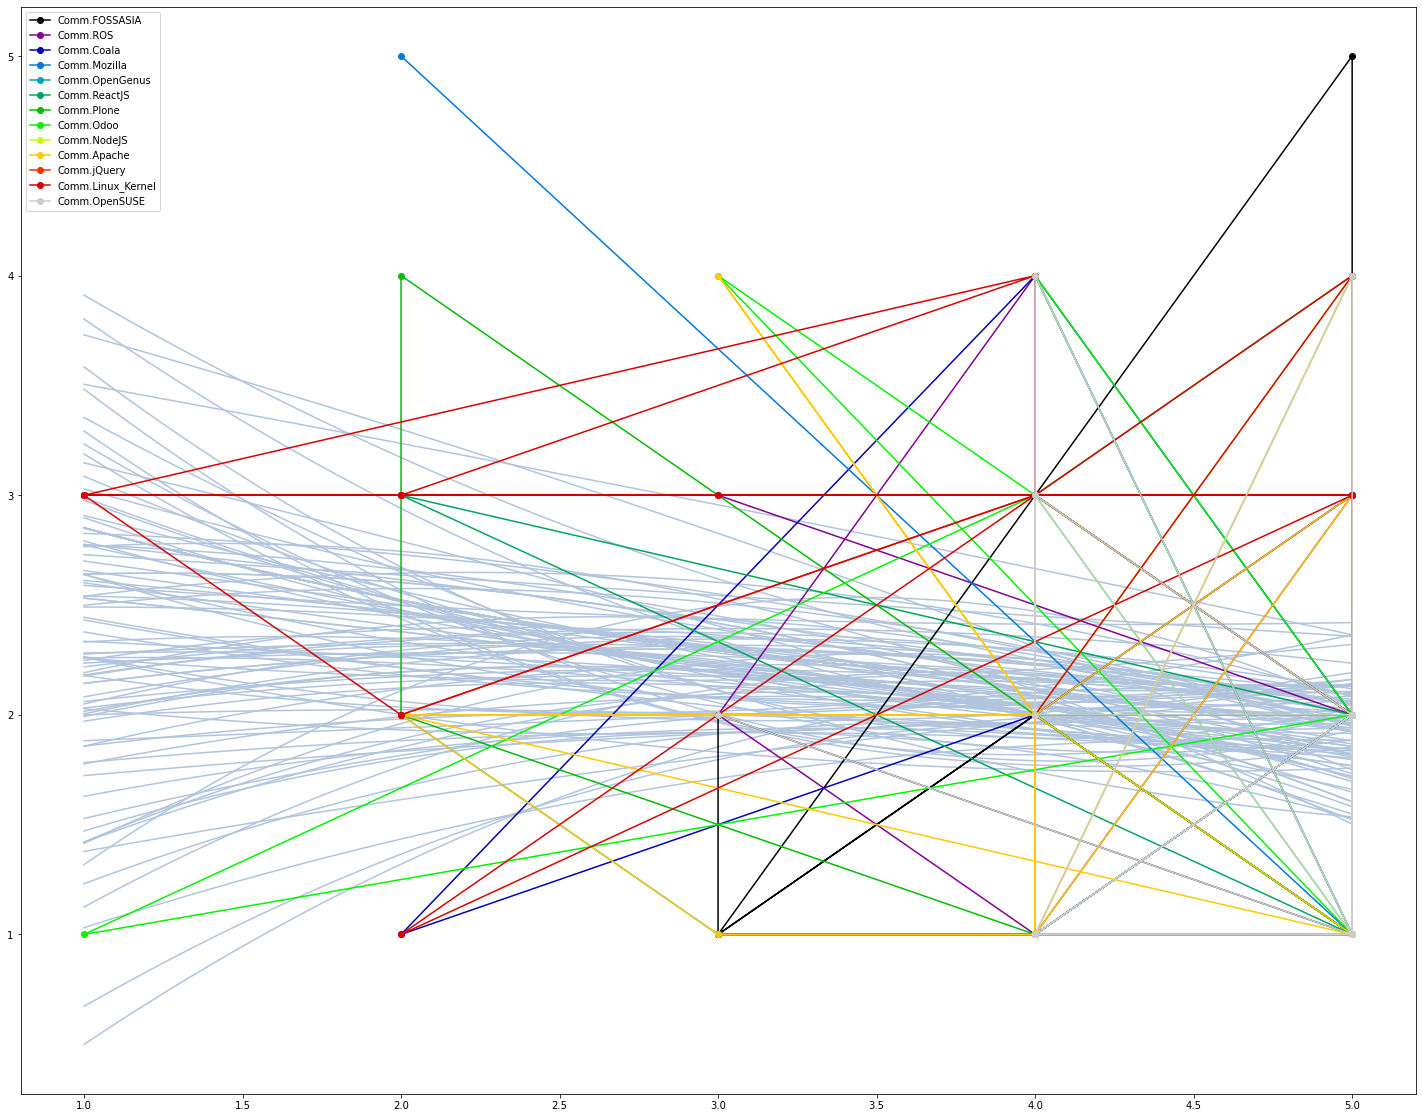

In [40]:
quadraticFunction = lambda xprime, i: trace_h2_quadratic[i]['β0_group_μ']+trace_h2_quadratic[i]['β1_group_μ']*xprime+trace_h2_quadratic[i]['β2_group_μ']*xprime**2
plot_all_data(quadraticFunction)

In [41]:
def plot_com_reg_quadratic_data(com_id,trace,num_ppc,ax,hdi=False):    
    V29_to_plot = np.array(get_relevant(communities[com_id], getIndexV29())[1])
    xprime = np.linspace(1,5,len(V29_to_plot))
    
    # Plot regression lines
    if not hdi:
        [ax.plot(xprime,
                 trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29_to_plot+trace[i]['β2'][com_id]*(V29_to_plot**2),
                 color='lightsteelblue')
         for i in np.random.randint(0,len(trace),num_ppc)]
    
    # Plot hdi
    else:
        az.plot_hdi(xprime,
                    [t.rvs(df=trace[i]['ν'],
                           loc=trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29_to_plot+trace[i]['β2'][com_id]*(V29_to_plot**2), 
                           scale=trace[i]['σ'])
                     for i in np.random.randint(low=0, high=len(trace), size=num_ppc)],
                    color='lightblue',
                    hdi_prob=0.95,
                    ax=ax)

    ax.plot(get_relevant(communities[com_id], getIndexV29())[1], get_relevant(communities[com_id], getIndexV31())[1],
             marker='o',linestyle=None,color='black',lw=0,
             label=communities[com_id])
#     ax.plot(get_relevant(com_id, 2)[1], get_relevant(com, 4)[1], "-", marker='o', color='black',lw=.8, label=com_id)


    ax.set_xlim(1,5)
    ax.set_ylim(-1,5)
    ax.set_title(communities[com_id])

C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\ProgramData\Minic

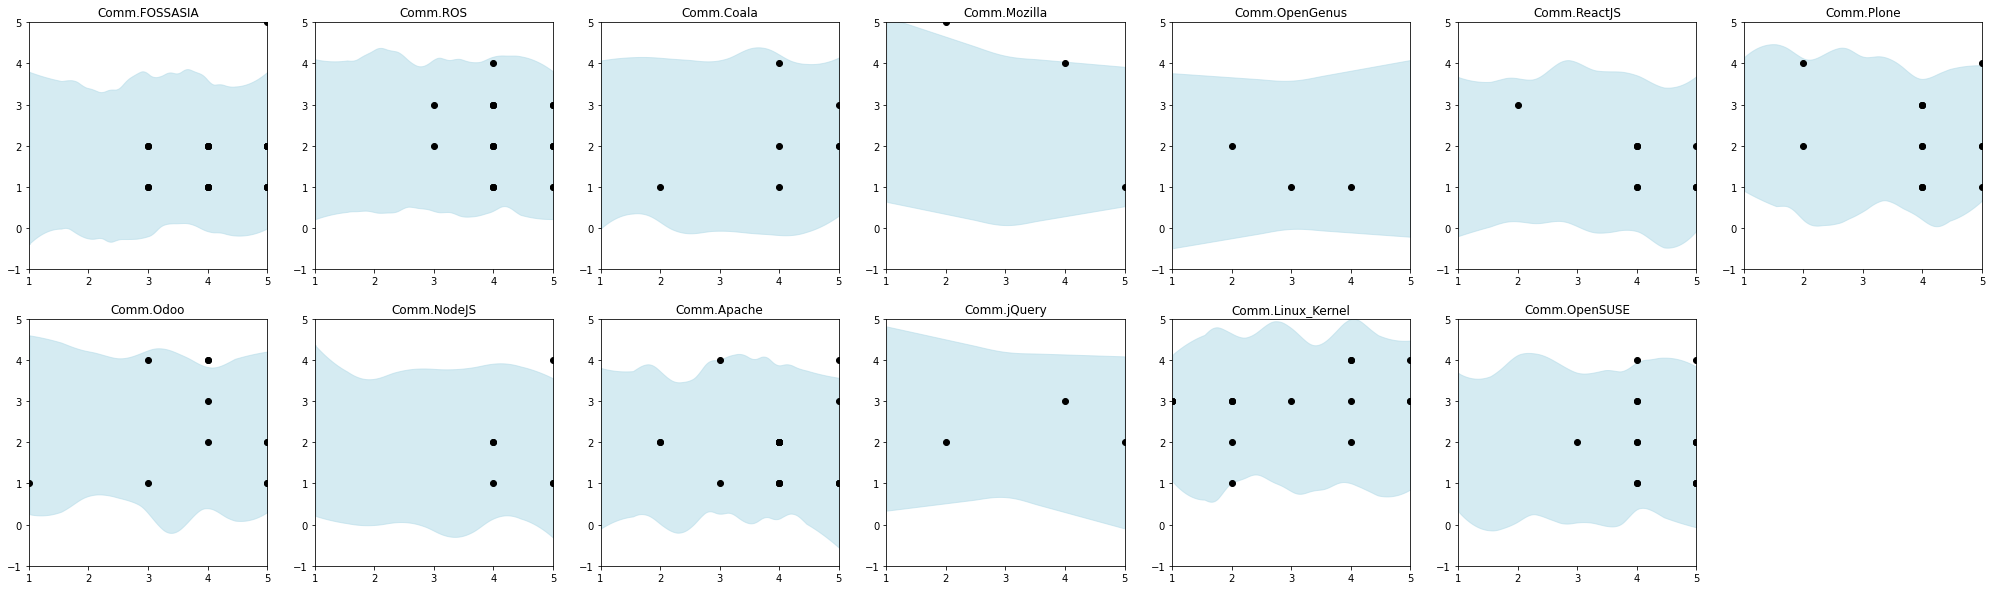

In [42]:
#plot individual
fig, axs = plt.subplots(nrows=2,ncols=7, figsize=(35,10))
flatten_axs = axs.ravel()
[plot_com_reg_quadratic_data(com_id=com_id,trace=trace_h2_quadratic,num_ppc=100,ax=ax,hdi=True) for (com_id,ax) in zip(com_ids,flatten_axs)]
[flatten_axs[i].axis('off') for i in range(len(com_ids),len(flatten_axs))]
plt.show()